In [5]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

from libs.MarkovModel import compute_context_aware_transition_matrix
from libs.MarkovModel import compute_transition_matrix
from libs.MarkovModel import compute_log_likelihood_and_perplexity
from libs import encode_float_filename, decode_float_filename, split_into_balanced_groups

In [6]:


dbParams_list = [0.01, 0.15]
direction_list = ["forward", "backward"]
mode_list = ["fixed", "adaptive"]
LEN_period = 1000
verbose = False

perpCF_results = {}
perpCA_results = {}

for dbParams, direction in zip(dbParams_list, direction_list):
    for mode in mode_list:
        perpCF_row = []
        perpCA_row = []
        for lenWindow in [10, 20, 30]:
            dbpString = encode_float_filename(dbParams)
            with open(f"Results/TrafficPredictor/evaluate/CA/{direction}_{lenWindow}_{mode}_{dbpString}_train.pkl", "rb") as file:
                resultsTrain = pickle.load(file)
            with open(f"Results/TrafficPredictor/evaluate/CA/{direction}_{lenWindow}_{mode}_{dbpString}_test.pkl", "rb") as file:
                resultsTest = pickle.load(file)

                trafficTargetDistribution = resultsTrain['classDistribu_predicted']
                trafficTarget = resultsTrain['trafficTarget_actual']
                trafficSource = resultsTrain['trafficSource_actual']
                transMatrixContextAware, _ = compute_context_aware_transition_matrix(trafficSource, trafficTargetDistribution, lenWindow)
                transMatrixContextFree = compute_transition_matrix(trafficSource, trafficTarget, lenWindow+1, alpha=1e-20)

                #N = np.floor(len(resultsTest['trafficSource_actual'])/LEN_period).astype(int)
                N = 1
                sourceTraffic = resultsTest['trafficSource_actual']
                targetTraffic = resultsTest['trafficTarget_actual']
                logLikeCA, perpCA = compute_log_likelihood_and_perplexity(transMatrixContextAware, sourceTraffic, targetTraffic, N=N)
                logLikeCF, perpCF = compute_log_likelihood_and_perplexity(transMatrixContextFree, sourceTraffic, targetTraffic, N=N)

                perpCF_row.append(np.mean(perpCF))
                perpCA_row.append(np.mean(perpCA))
                if verbose == True:
                    print(np.sum(transMatrixContextFree, axis=1))
                    print(np.sum(transMatrixContextAware, axis=1))
                    print(f"Imporvement: {abs(np.mean(perpCA)-np.mean(perpCF))/np.mean(perpCF)}")
                    print(f"perpCF: {np.mean(perpCF)}, perpCA: {np.mean(perpCA)}")
                    print(f"logLikeCF: {np.mean(logLikeCF)}, logLikeCA: {np.mean(logLikeCA)}")

                    plt.plot(logLikeCF)
                    plt.plot(logLikeCA)
                    plt.show()
                    plt.plot(perpCF)
                    plt.plot(perpCA)
                    plt.show()
        perpCF_results[(direction, mode)] = np.array(perpCF_row)
        perpCA_results[(direction, mode)] = np.array(perpCA_row)  

#perpCF_results = np.array(perpCF_results)
#perpCA_results = np.array(perpCA_results)


In [7]:
print(perpCF_results)

{('forward', 'fixed'): array([ 4.76998872,  9.38276419, 14.96043713]), ('forward', 'adaptive'): array([ 4.01671661,  7.07838781, 12.01582782]), ('backward', 'fixed'): array([ 7.27453196, 16.34492632, 40.13820782]), ('backward', 'adaptive'): array([ 7.02383444, 17.55301019, 33.71546949])}


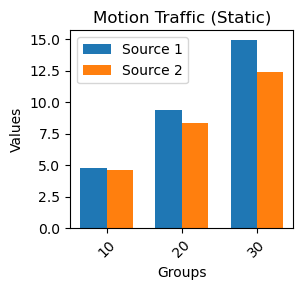

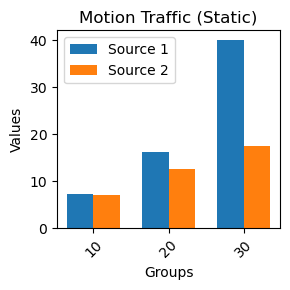

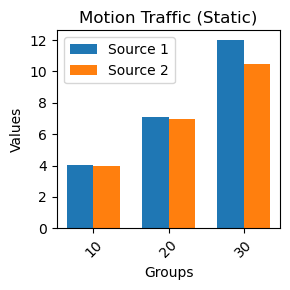

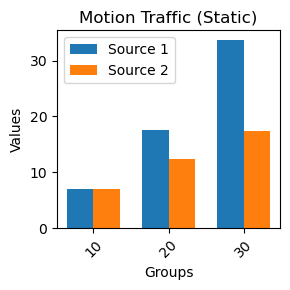

In [8]:
def plot_comparison_bar_graph(source1: np.ndarray, source2: np.ndarray, labels: list = None, title: str = 'Comparison of Two Sources', figsize=(10,6)) -> None:
    # Ensure the inputs are 2D arrays (N, 1)
    source1 = source1.reshape(-1, 1)
    source2 = source2.reshape(-1, 1)

    # Check if both arrays have the same length
    if source1.shape[0] != source2.shape[0]:
        raise ValueError("Both sources must have the same number of groups (N).")

    # Setting the number of groups (N)
    N = source1.shape[0]

    # Creating index for groups
    indices = np.arange(N)

    # Setting bar width
    bar_width = 0.35

    # Plotting bars
    plt.figure(figsize=figsize)
    plt.bar(indices - bar_width/2, source1.flatten(), width=bar_width, label='Source 1')
    plt.bar(indices + bar_width/2, source2.flatten(), width=bar_width, label='Source 2')

    # Adding labels
    if labels is not None and len(labels) == N:
        plt.xticks(indices, labels, rotation=45)
    else:
        plt.xticks(indices)

    plt.title(title)
    plt.xlabel('Groups')
    plt.ylabel('Values')
    plt.legend()
    plt.tight_layout()

    # Displaying the plot
    plt.show()

figsize = (3,3)
configure = ('forward', 'fixed')
plot_comparison_bar_graph(perpCF_results[configure], perpCA_results[configure], ["10", "20", "30"], 'Motion Traffic (Static)', figsize)
configure = ('backward', 'fixed')
plot_comparison_bar_graph(perpCF_results[configure], perpCA_results[configure], ["10", "20", "30"], 'Motion Traffic (Static)', figsize)
configure = ('forward', 'adaptive')
plot_comparison_bar_graph(perpCF_results[configure], perpCA_results[configure], ["10", "20", "30"], 'Motion Traffic (Static)', figsize)
configure = ('backward', 'adaptive')
plot_comparison_bar_graph(perpCF_results[configure], perpCA_results[configure], ["10", "20", "30"], 'Motion Traffic (Static)', figsize)

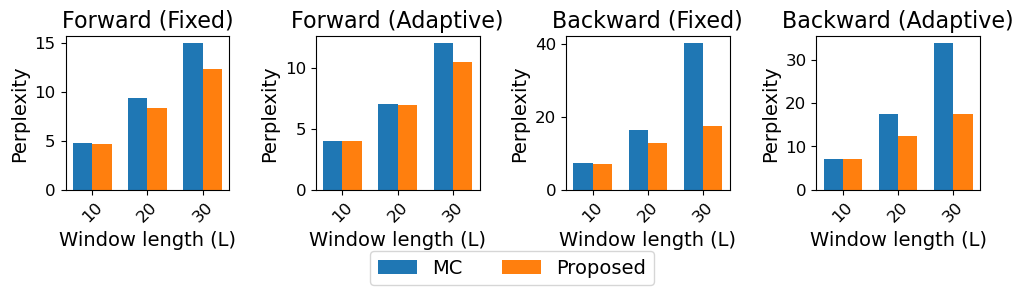

In [9]:
def plot_combined_comparison_bar_graph(perpCF_results: dict, perpCA_results: dict, configurations, subtitles, figsize=(12, 12), 
                                       title_fontsize=14, label_fontsize=12, tick_fontsize=10, legend_fontsize=12) -> None:
    # Creating the figure with 1x4 subplots
    fig, axs = plt.subplots(1, 4, figsize=figsize)
    axs = axs.ravel()  # Flatten for easier indexing

    for i, config in enumerate(configurations):
        ax = axs[i]
        source1 = perpCF_results[config].reshape(-1, 1)
        source2 = perpCA_results[config].reshape(-1, 1)

        # Ensuring equal length of sources
        if source1.shape[0] != source2.shape[0]:
            raise ValueError("Both sources must have the same number of groups (N).")

        N = source1.shape[0]
        indices = np.arange(N)
        bar_width = 0.35

        # Plotting bars
        ax.bar(indices - bar_width / 2, source1.flatten(), width=bar_width, label='MC')
        ax.bar(indices + bar_width / 2, source2.flatten(), width=bar_width, label='Proposed')

        ax.set_title(f'{subtitles[i]}', fontsize=title_fontsize)
        ax.set_xlabel('Window length (L)', fontsize=label_fontsize)
        ax.set_ylabel('Perplexity', fontsize=label_fontsize)
        ax.set_xticks(indices)
        ax.set_xticklabels(['10', '20', '30'], rotation=45, fontsize=tick_fontsize)
        ax.tick_params(axis='y', labelsize=tick_fontsize)

    # Adjust layout and add one single legend
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=2, fontsize=legend_fontsize)

    plt.tight_layout(rect=[0, 0.1, 1, 1])  # Adjust layout to fit the legend
    return fig

configurations = [
    ('forward', 'fixed'),
    ('forward', 'adaptive'),
    ('backward', 'fixed'),
    ('backward', 'adaptive')
]
subtitles = [
    'Forward (Fixed)',
    'Forward (Adaptive)',
    'Backward (Fixed)',
    'Backward (Adaptive)'
]
fig = plot_combined_comparison_bar_graph(
    perpCF_results, 
    perpCA_results, 
    configurations, 
    subtitles, 
    figsize=(10, 3), 
    title_fontsize=16, 
    label_fontsize=14, 
    tick_fontsize=12, 
    legend_fontsize=14
)
fig.savefig("C:/Users/Ye/Documents/YuYeh_Documents/L2S/Conference_Writing/EW2025/figures/preplexity.png", format='png', dpi=300)